In [1]:
year=2019
month=10

In [2]:
import pandas as pd
import sys
sys.path.append('../../py')
import db
import weighted
import inspect
import matplotlib.pyplot as plt
plt.rcParams['font.sans-serif']=['SimHei'] #用来正常显示中文标签
plt.rcParams['axes.unicode_minus']=False #用来正常显示负号
%matplotlib inline
from mpl_toolkits.basemap import Basemap
import seaborn as sns
import scipy.stats as stats
import numpy as np
import math


In [3]:
from matplotlib.font_manager import _rebuild

_rebuild() #reload一下

In [4]:
conn=db.get_conn()

In [5]:

cities = """
('北京','上海','深圳','杭州','广州','南京','苏州','成都','东莞','西安','武汉','天津','长沙',
'宁波','福州','大连','重庆','青岛','济南','合肥','长春','昆明','郑州','沈阳','哈尔滨','厦门')
"""
data_original=pd.read_sql(sql=f"select * from _{year}{month:02} where monthly_salary>0 and monthly_salary<80000 and city in {cities}", con=conn)


In [6]:
error_job_ids=['104660258','104142922','108434795','101357291','106253516','110368302','111391233','108665401','109277048'
                  ,'73857191','108584955','102824950','102824949','111391233','110884556']
data=data_original[~data_original.job_id.isin(error_job_ids)]

In [7]:
del data['publish_date']
del data['published_on_weekend']
del data['title']
del data['company_title']
del data['company_description']
del data['job_description']
del data['job_id']

In [8]:
#Common Functions
def get_sub_stats_by_col(data, col):
    categories=data[col].unique()
    salary_mean=[]
    salary_95_min=[]
    salary_95_max=[]
    salary_median=[]

    count=[]
    
    categorys_out=[]
    for category in categories:
        #print(feature)
        idata=data[data[col]==category]
        headcount=idata.headcount.sum()
        values = idata.monthly_salary.values
        weights = idata.headcount.values
        #print(str(headcount))
        if headcount==0:
            continue
        
        salary_mean.append(np.average(values, weights=weights))
        

        q = weighted.weighted_quantile(values,[0.025,0.5,0.975],weights)
        salary_95_min.append(q[0])
        salary_median.append(q[1])
        salary_95_max.append(q[2])
        count.append(idata.headcount.sum())
        categorys_out.append(category)
    sub_data=pd.DataFrame()
    sub_data[col]=[c for c in categorys_out]
    sub_data['平均工资']=salary_mean
    sub_data['最低工资']=salary_95_min
    sub_data['中位数']=salary_median
    sub_data['最高工资']=salary_95_max
    sub_data['招聘人数']=count
    sub_data['百分比']=count/np.sum(count)
    sub_data=sub_data.sort_values(by='平均工资', ascending=False)

    return sub_data

data_format={"百分比":"{:.2%}","平均工资":"{:.0f}","中位数":"{:.0f}","最低工资":"{:.0f}","最高工资":"{:.0f}"}

translate_dict={}


In [13]:
data_location = pd.read_csv('../city_locations.csv')
data_location=data_location.set_index('city')

# 程序员工资

In [8]:
data_city=get_sub_stats_by_col(data,'city')
data_city.style.format(data_format)

,city,平均工资,最低工资,中位数,最高工资,招聘人数,百分比
1,北京,16709,3750,14583,45000,25000,9.70%
2,上海,16544,5250,15000,37500,44305,17.19%
8,深圳,16103,5250,14500,37500,37579,14.58%
3,杭州,14758,3500,12500,33333,13475,5.23%
4,广州,13577,3750,12500,30000,28798,11.17%
9,南京,13243,4500,12500,27500,13580,5.27%
6,成都,12223,3500,11500,29166,11689,4.54%
12,苏州,11971,3750,11500,25862,7471,2.90%
15,东莞,11959,3750,11500,24000,2822,1.10%
0,武汉,11549,3750,10500,25000,14905,5.78%


In [9]:
def describe(data_city, career):
    
    for index, row in data_city.iterrows():
        print(f"{year}年{month}月{row[0]}招收{career}{row[5]}人。{year}年{month}月{row[0]}{career}平均工资{row[1]:.0f}元，工资中位数{row[3]:.0f}元，其中95%的人的工资介于{row[2]:.0f}元到{row[4]:.0f}元。\r\n")


In [10]:
describe(data_city,'程序员')

2019年10月北京招收程序员25000人。2019年10月北京程序员平均工资16709元，工资中位数14583元，其中95%的人的工资介于3750元到45000元。

2019年10月上海招收程序员44305人。2019年10月上海程序员平均工资16544元，工资中位数15000元，其中95%的人的工资介于5250元到37500元。

2019年10月深圳招收程序员37579人。2019年10月深圳程序员平均工资16103元，工资中位数14500元，其中95%的人的工资介于5250元到37500元。

2019年10月杭州招收程序员13475人。2019年10月杭州程序员平均工资14758元，工资中位数12500元，其中95%的人的工资介于3500元到33333元。

2019年10月广州招收程序员28798人。2019年10月广州程序员平均工资13577元，工资中位数12500元，其中95%的人的工资介于3750元到30000元。

2019年10月南京招收程序员13580人。2019年10月南京程序员平均工资13243元，工资中位数12500元，其中95%的人的工资介于4500元到27500元。

2019年10月成都招收程序员11689人。2019年10月成都程序员平均工资12223元，工资中位数11500元，其中95%的人的工资介于3500元到29166元。

2019年10月苏州招收程序员7471人。2019年10月苏州程序员平均工资11971元，工资中位数11500元，其中95%的人的工资介于3750元到25862元。

2019年10月东莞招收程序员2822人。2019年10月东莞程序员平均工资11959元，工资中位数11500元，其中95%的人的工资介于3750元到24000元。

2019年10月武汉招收程序员14905人。2019年10月武汉程序员平均工资11549元，工资中位数10500元，其中95%的人的工资介于3750元到25000元。

2019年10月长沙招收程序员6101人。2019年10月长沙程序员平均工资11225元，工资中位数10500元，其中95%的人的工资介于3910元到25000元。

2019年10月西安招收程序员7165人。2019年10月西安程序员平均工资11194元，工资中位数10500元，其中95%的人的工资介

In [12]:
from mpl_toolkits.basemap import Basemap

In [11]:
def draw_map(data_city,headcount_scale, title):


    #cities = []
    scale = 5

    locations = [(116.407526, 39.90403),(120, 30)]
    #fig=plt.figure(figsize=(18, 16), dpi= 80, facecolor='w', edgecolor='k')
    plt.rcParams['figure.figsize'] = [13, 13]
    #plt.figure(figsize = (10,5))
    fig, ax = plt.subplots()
    fig.title=title
    fig.figsize=(10,5)
    fig.dpi=80
    cn_map= Basemap(llcrnrlon=77, llcrnrlat=14, urcrnrlon=140, urcrnrlat=51, \
               projection='lcc', lat_1=33, lat_2=45, lon_0=100) # ‘lcc'将投影方式设置为兰伯特投影

    # load the shapefile, use the name 'states'
    cn_map.readshapefile(r'D:/data/basemap/gadm36_CHN_shp/gadm36_CHN_1', name='china', drawbounds=True, color='gray')
    cn_map.readshapefile(r'D:/data/basemap/gadm36_TWN_shp/gadm36_TWN_1', name='taiwan', drawbounds=True, color='gray')
    #geolocator = Nominatim(user_agent="my-application")



    salary_min=data_city['平均工资'].min()
    salary_max=data_city['平均工资'].max()
    salary_middle = (salary_min+salary_max)/2
    salary_scale=salary_max-salary_min

    for index, row in data_city.iterrows():
        city=row[0]
        
        longitude = data_location.loc[city,'longitude']
        latitude = data_location.loc[city,'latitude']
        salary=row[1]
        headcount=row[5]
        #color
        color_red=0
        color_green=0
        color_blue=0
        if salary>salary_middle:
            color_red = 255 #int((salary - salary_middle) / (salary_scale/2)*255)
            color_green = int((salary_max - salary) / (salary_scale/2)*255)
        else:
            color_blue = int((salary_middle - salary) / (salary_scale/2)*255)
            color_green = int((salary - salary_min) / (salary_scale/2)*255)
            color_red = int((salary - salary_min) / (salary_scale/2)*255)

        color = '#{:02x}{:02x}{:02x}'.format(color_red,color_green,color_blue)


        x, y = cn_map(longitude,latitude)
        cn_map.plot(x,y,marker='o',color=color,markersize=int(math.sqrt(headcount/headcount_scale))+8)
        #ax.annotate(city, (x,y), xytext=(5, 5), textcoords='offset points', fontsize=15)
        #"{}{:.0f}".format(city_cn, salary)
        #ax.text(x+5, y+5,city , fontweight='bold', fontsize=int(headcount/2500+12))
        fontsize=int(math.sqrt(headcount/headcount_scale))+13
        if city == '杭州':
            x=x-400000
            y=y+10000
        elif city=='广州':
            x=x-400000
            y=y+10000
        elif city=='合肥':
            x=x-300000
            y=y+10000
        elif city=='深圳':
            y=y-100000
        elif city=='南京':
            x=x-100000
        elif city=='天津':
            y=y-50000
        elif city=='上海':
            x=x+50000
        elif city=='武汉':
            y=y-50000
        elif city=='厦门':
            pass
        elif city=='福州':
            pass
        elif city=='苏州':
            y=y-100000
            pass
        elif city=='宁波':
            y=y-100000
            pass

        ax.text(x, y, "{}{:.0f}k".format(city, np.round(salary/1000)), fontweight='bold', fontsize=fontsize, bbox={'facecolor':color, 'alpha':0.3, 'pad':0})
    ax.text(1100000, 1077845, "https://github.com/juwikuang/china_job_survey".format(city, np.round(salary/1000)), fontweight='bold',color='#999999', fontsize=20, bbox={'facecolor':'#eeeeee', 'alpha':0.4, 'pad':0})    
    ax.text(205805, 107845, "https://github.com/juwikuang/china_job_survey".format(city, np.round(salary/1000)), fontweight='bold',color='#999999', fontsize=20, bbox={'facecolor':'#eeeeee', 'alpha':0.4, 'pad':0})    
    ax.text(805805, 4007845, title.format(city, np.round(salary/1000)), fontweight='bold',color='#111111', fontsize=25)    
    ax.text(805805, 3807845, "（城市大小代表招聘数量，颜色代表工资，红色最高，黄色次之，蓝最少）", fontweight='bold',color='#111111', fontsize=13)    
    #cn_map.drawcoastlines() #绘制海岸线
    #cn_map.drawcountries(linewidth=1.5) #绘制国家边界线
    plt.show()


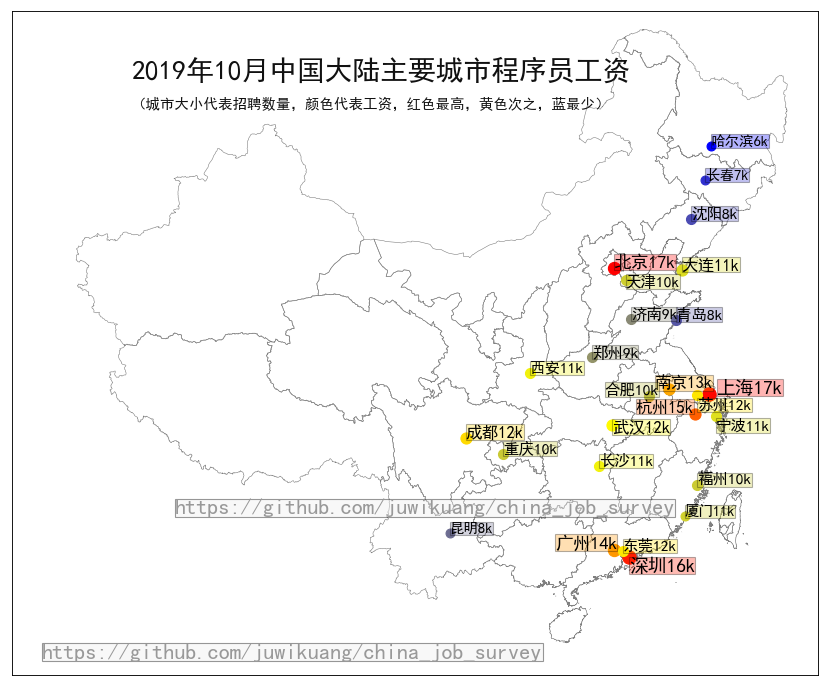

In [14]:
draw_map(data_city,2000,f'{year}年{month}月中国大陆主要城市程序员工资')

# 算法工程师

In [15]:
data_city_algorithm=get_sub_stats_by_col(data[data.career=='算法工程师'],'city')
data_city_algorithm.style.format(data_format)

,city,平均工资,最低工资,中位数,最高工资,招聘人数,百分比
0,北京,22933,5250,21500,55000,2930,12.85%
1,上海,22384,6500,20833,45833,4635,20.33%
6,深圳,20910,7000,20000,45000,3744,16.42%
4,杭州,19379,3750,17500,45000,1440,6.32%
3,广州,17975,5099,17000,37500,2407,10.56%
10,南京,17342,5768,16500,32500,1155,5.07%
15,苏州,16454,4342,15000,34571,944,4.14%
9,成都,15599,5250,14000,31250,956,4.19%
12,厦门,15387,7550,14000,22500,120,0.53%
18,合肥,15284,5250,13250,37500,300,1.32%


In [16]:
describe(data_city_algorithm,'算法工程师')

2019年10月北京招收算法工程师2930人。2019年10月北京算法工程师平均工资22933元，工资中位数21500元，其中95%的人的工资介于5250元到55000元。

2019年10月上海招收算法工程师4635人。2019年10月上海算法工程师平均工资22384元，工资中位数20833元，其中95%的人的工资介于6500元到45833元。

2019年10月深圳招收算法工程师3744人。2019年10月深圳算法工程师平均工资20910元，工资中位数20000元，其中95%的人的工资介于7000元到45000元。

2019年10月杭州招收算法工程师1440人。2019年10月杭州算法工程师平均工资19379元，工资中位数17500元，其中95%的人的工资介于3750元到45000元。

2019年10月广州招收算法工程师2407人。2019年10月广州算法工程师平均工资17975元，工资中位数17000元，其中95%的人的工资介于5099元到37500元。

2019年10月南京招收算法工程师1155人。2019年10月南京算法工程师平均工资17342元，工资中位数16500元，其中95%的人的工资介于5768元到32500元。

2019年10月苏州招收算法工程师944人。2019年10月苏州算法工程师平均工资16454元，工资中位数15000元，其中95%的人的工资介于4342元到34571元。

2019年10月成都招收算法工程师956人。2019年10月成都算法工程师平均工资15599元，工资中位数14000元，其中95%的人的工资介于5250元到31250元。

2019年10月厦门招收算法工程师120人。2019年10月厦门算法工程师平均工资15387元，工资中位数14000元，其中95%的人的工资介于7550元到22500元。

2019年10月合肥招收算法工程师300人。2019年10月合肥算法工程师平均工资15284元，工资中位数13250元，其中95%的人的工资介于5250元到37500元。

2019年10月武汉招收算法工程师1143人。2019年10月武汉算法工程师平均工资15115元，工资中位数15000元，其中95%的人的工资介于3802元到27500元。

2019年10月宁波招收算法工程师153人。2019年10月宁波算法工程

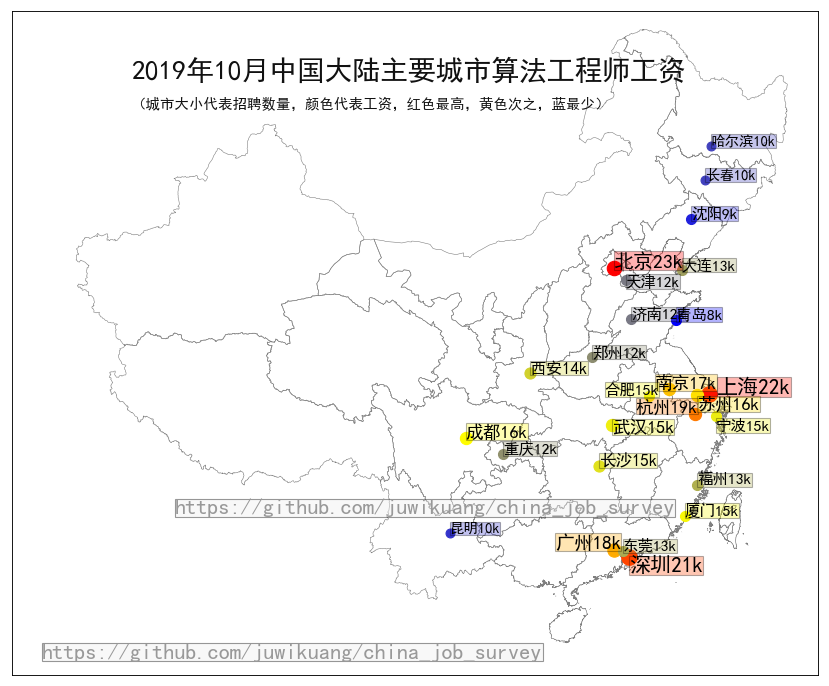

In [17]:
draw_map(data_city_algorithm,100,f'{year}年{month}月中国大陆主要城市算法工程师工资')

# 区块链工程师

In [9]:
data_blockchain=get_sub_stats_by_col(data[(data.expert_blockchain==1)],'city')

data_blockchain.style.format(data_format)

,city,平均工资,最低工资,中位数,最高工资,招聘人数,百分比
1,上海,27586,11500,22917,72857,64,11.33%
5,深圳,21690,2500,22500,40000,87,15.40%
4,成都,20854,11500,25000,39617,24,4.25%
6,北京,19319,3980,15625,40000,47,8.32%
11,郑州,18643,9000,18643,22500,7,1.24%
2,广州,18170,6000,15000,36167,212,37.52%
10,大连,17500,17500,17500,17500,2,0.35%
7,杭州,16809,2500,18300,29166,31,5.49%
9,南京,15455,12500,15625,17500,11,1.95%
13,重庆,13750,10000,13750,17500,4,0.71%


In [ ]:
describe(data_blockchain,'区块链工程师')

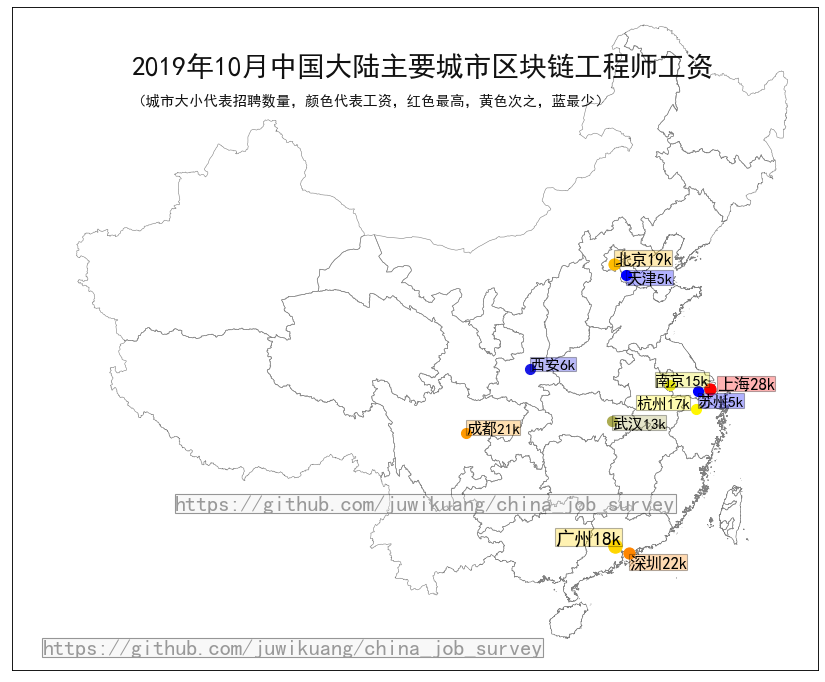

In [14]:
draw_map(data_blockchain[data_blockchain['招聘人数']>10],10,f'{year}年{month}月中国大陆主要城市区块链工程师工资')

# 系统架构师

In [18]:
data_city_architect=get_sub_stats_by_col(data[data.career=='系统架构师'],'city')
data_city_architect.style.format(data_format)

,city,平均工资,最低工资,中位数,最高工资,招聘人数,百分比
6,北京,31682,8400,30000,60000,1088,13.01%
9,深圳,26623,7221,26500,52500,1153,13.78%
4,上海,24497,7000,22500,50000,1865,22.30%
5,杭州,24496,8411,25000,45000,447,5.34%
2,南京,21277,7375,20000,38312,395,4.72%
3,广州,20579,5250,20000,45000,1244,14.87%
10,成都,19232,6760,17500,45000,312,3.73%
11,东莞,19110,6988,21700,30500,99,1.18%
1,武汉,17930,5681,17500,35000,366,4.38%
0,大连,17350,7950,17500,24917,82,0.98%


In [19]:
describe(data_city_architect,'系统架构师')

2019年10月北京招收系统架构师1088人。2019年10月北京系统架构师平均工资31682元，工资中位数30000元，其中95%的人的工资介于8400元到60000元。

2019年10月深圳招收系统架构师1153人。2019年10月深圳系统架构师平均工资26623元，工资中位数26500元，其中95%的人的工资介于7221元到52500元。

2019年10月上海招收系统架构师1865人。2019年10月上海系统架构师平均工资24497元，工资中位数22500元，其中95%的人的工资介于7000元到50000元。

2019年10月杭州招收系统架构师447人。2019年10月杭州系统架构师平均工资24496元，工资中位数25000元，其中95%的人的工资介于8411元到45000元。

2019年10月南京招收系统架构师395人。2019年10月南京系统架构师平均工资21277元，工资中位数20000元，其中95%的人的工资介于7375元到38312元。

2019年10月广州招收系统架构师1244人。2019年10月广州系统架构师平均工资20579元，工资中位数20000元，其中95%的人的工资介于5250元到45000元。

2019年10月成都招收系统架构师312人。2019年10月成都系统架构师平均工资19232元，工资中位数17500元，其中95%的人的工资介于6760元到45000元。

2019年10月东莞招收系统架构师99人。2019年10月东莞系统架构师平均工资19110元，工资中位数21700元，其中95%的人的工资介于6988元到30500元。

2019年10月武汉招收系统架构师366人。2019年10月武汉系统架构师平均工资17930元，工资中位数17500元，其中95%的人的工资介于5681元到35000元。

2019年10月大连招收系统架构师82人。2019年10月大连系统架构师平均工资17350元，工资中位数17500元，其中95%的人的工资介于7950元到24917元。

2019年10月西安招收系统架构师211人。2019年10月西安系统架构师平均工资17191元，工资中位数17500元，其中95%的人的工资介于6194元到33612元。

2019年10月苏州招收系统架构师206人。2019年10月苏州系统架构师平均工资

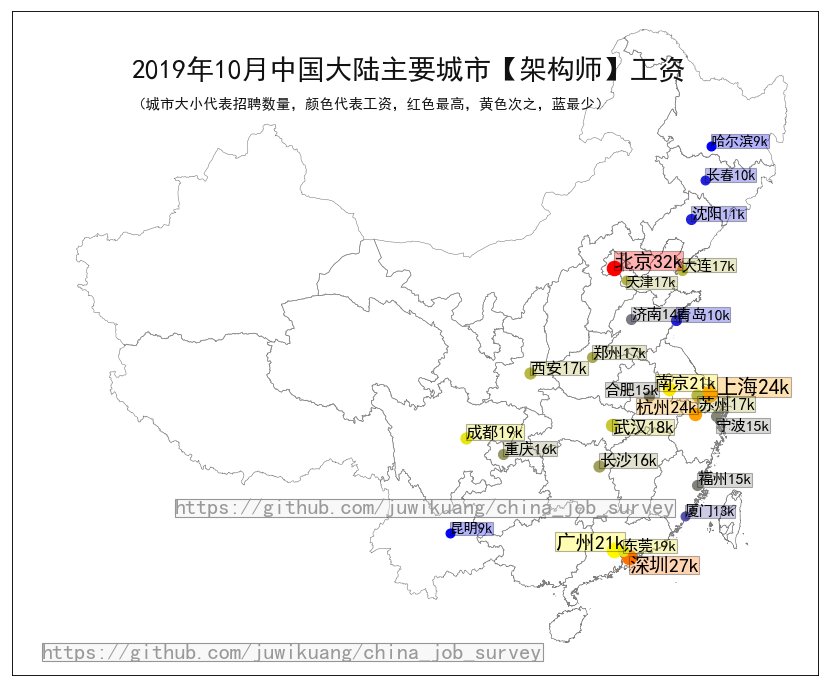

In [20]:
draw_map(data_city_architect,40,f'{year}年{month}月中国大陆主要城市【架构师】工资')

# 生物信息工程师

In [21]:
data_bio=get_sub_stats_by_col(data[data.career=='生物信息工程师'],'city')
data_bio.style.format(data_format)

,city,平均工资,最低工资,中位数,最高工资,招聘人数,百分比
0,北京,14286,12500,14167,15000,7,21.88%
3,苏州,12500,12500,12500,12500,1,3.12%
5,杭州,12000,11500,12000,12500,2,6.25%
1,广州,11375,7000,11375,14000,8,25.00%
6,上海,9800,8000,9800,12500,5,15.62%
4,武汉,9000,9000,9000,9000,1,3.12%
7,南京,9000,9000,9000,9000,3,9.38%
2,深圳,7500,7500,7500,7500,5,15.62%


In [22]:
describe(data_bio,'生物信息工程师')

2019年10月北京招收生物信息工程师7人。2019年10月北京生物信息工程师平均工资14286元，工资中位数14167元，其中95%的人的工资介于12500元到15000元。

2019年10月苏州招收生物信息工程师1人。2019年10月苏州生物信息工程师平均工资12500元，工资中位数12500元，其中95%的人的工资介于12500元到12500元。

2019年10月杭州招收生物信息工程师2人。2019年10月杭州生物信息工程师平均工资12000元，工资中位数12000元，其中95%的人的工资介于11500元到12500元。

2019年10月广州招收生物信息工程师8人。2019年10月广州生物信息工程师平均工资11375元，工资中位数11375元，其中95%的人的工资介于7000元到14000元。

2019年10月上海招收生物信息工程师5人。2019年10月上海生物信息工程师平均工资9800元，工资中位数9800元，其中95%的人的工资介于8000元到12500元。

2019年10月武汉招收生物信息工程师1人。2019年10月武汉生物信息工程师平均工资9000元，工资中位数9000元，其中95%的人的工资介于9000元到9000元。

2019年10月南京招收生物信息工程师3人。2019年10月南京生物信息工程师平均工资9000元，工资中位数9000元，其中95%的人的工资介于9000元到9000元。

2019年10月深圳招收生物信息工程师5人。2019年10月深圳生物信息工程师平均工资7500元，工资中位数7500元，其中95%的人的工资介于7500元到7500元。



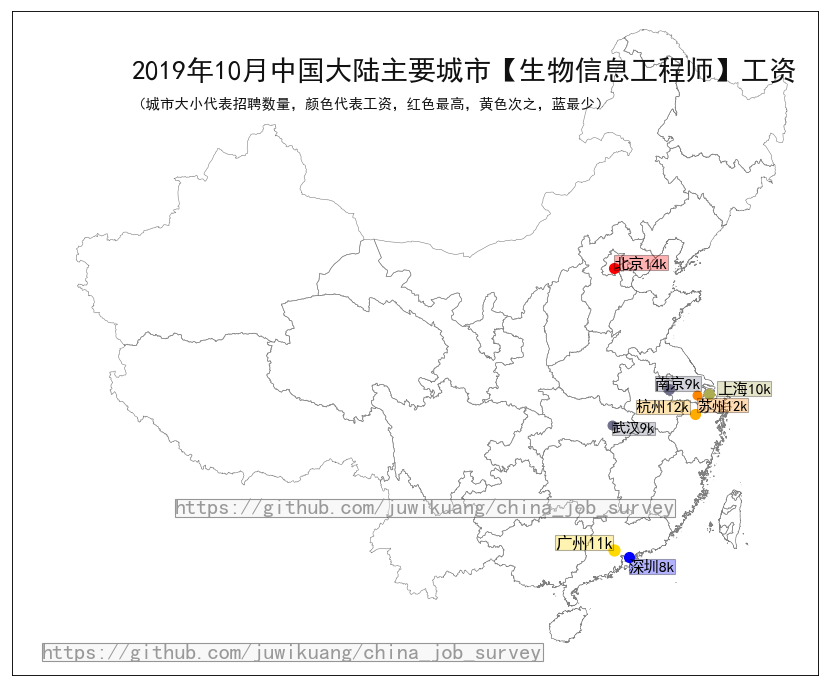

In [23]:
draw_map(data_bio,2,f'{year}年{month}月中国大陆主要城市【生物信息工程师】工资')

# 爬虫工程师

In [24]:
data_spider=get_sub_stats_by_col(data[data.career=='爬虫工程师'],'city')
data_spider=data_spider[data_spider['招聘人数']>10]
data_spider.style.format(data_format)

,city,平均工资,最低工资,中位数,最高工资,招聘人数,百分比
9,南京,15432,11517,15000,20000,22,5.96%
1,广州,14171,2500,12500,37500,38,10.30%
4,上海,14061,5046,12500,28812,106,28.73%
5,北京,13840,1750,12500,33438,25,6.78%
0,武汉,12031,7000,12000,20000,16,4.34%
13,杭州,11500,10500,11643,13000,14,3.79%
3,深圳,10869,5250,10500,22142,69,18.70%
6,长沙,9306,7000,9000,11500,18,4.88%
10,成都,6490,2250,5650,14000,24,6.50%


In [25]:
describe(data_spider, '爬虫工程师')

2019年10月南京招收爬虫工程师22人。2019年10月南京爬虫工程师平均工资15432元，工资中位数15000元，其中95%的人的工资介于11517元到20000元。

2019年10月广州招收爬虫工程师38人。2019年10月广州爬虫工程师平均工资14171元，工资中位数12500元，其中95%的人的工资介于2500元到37500元。

2019年10月上海招收爬虫工程师106人。2019年10月上海爬虫工程师平均工资14061元，工资中位数12500元，其中95%的人的工资介于5046元到28812元。

2019年10月北京招收爬虫工程师25人。2019年10月北京爬虫工程师平均工资13840元，工资中位数12500元，其中95%的人的工资介于1750元到33438元。

2019年10月武汉招收爬虫工程师16人。2019年10月武汉爬虫工程师平均工资12031元，工资中位数12000元，其中95%的人的工资介于7000元到20000元。

2019年10月杭州招收爬虫工程师14人。2019年10月杭州爬虫工程师平均工资11500元，工资中位数11643元，其中95%的人的工资介于10500元到13000元。

2019年10月深圳招收爬虫工程师69人。2019年10月深圳爬虫工程师平均工资10869元，工资中位数10500元，其中95%的人的工资介于5250元到22142元。

2019年10月长沙招收爬虫工程师18人。2019年10月长沙爬虫工程师平均工资9306元，工资中位数9000元，其中95%的人的工资介于7000元到11500元。

2019年10月成都招收爬虫工程师24人。2019年10月成都爬虫工程师平均工资6490元，工资中位数5650元，其中95%的人的工资介于2250元到14000元。



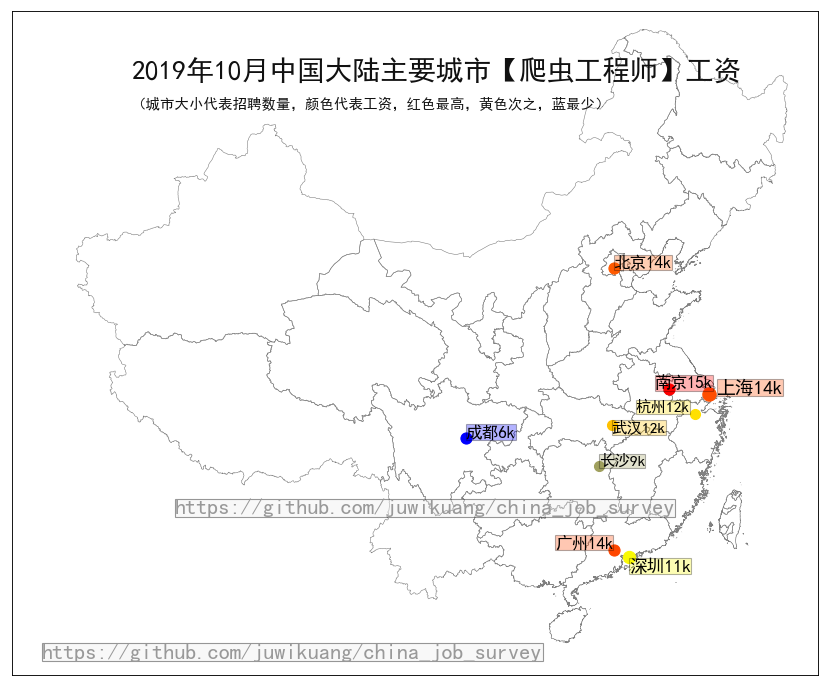

In [26]:
draw_map(data_spider,5,f'{year}年{month}月中国大陆主要城市【爬虫工程师】工资')

# Java程序员

In [27]:
data_java=get_sub_stats_by_col(data[(data.pl_java==1)],'city')
data_java.style.format(data_format)

,city,平均工资,最低工资,中位数,最高工资,招聘人数,百分比
6,上海,16697,5500,15000,35000,19216,16.25%
7,深圳,16494,6500,15000,37500,16083,13.60%
4,北京,15541,3750,13000,37500,12072,10.21%
1,杭州,14960,3000,13000,31250,6640,5.62%
2,广州,13892,4000,12500,30000,13943,11.79%
5,南京,12982,3983,12500,25000,7406,6.26%
19,东莞,12626,3971,12500,24722,1058,0.89%
11,苏州,11724,4750,11000,25000,2515,2.13%
3,成都,11671,2500,11000,25000,4844,4.10%
0,武汉,11329,5000,10500,25000,5945,5.03%


In [28]:
describe(data_java, 'Java程序员')

2019年10月上海招收Java程序员19216人。2019年10月上海Java程序员平均工资16697元，工资中位数15000元，其中95%的人的工资介于5500元到35000元。

2019年10月深圳招收Java程序员16083人。2019年10月深圳Java程序员平均工资16494元，工资中位数15000元，其中95%的人的工资介于6500元到37500元。

2019年10月北京招收Java程序员12072人。2019年10月北京Java程序员平均工资15541元，工资中位数13000元，其中95%的人的工资介于3750元到37500元。

2019年10月杭州招收Java程序员6640人。2019年10月杭州Java程序员平均工资14960元，工资中位数13000元，其中95%的人的工资介于3000元到31250元。

2019年10月广州招收Java程序员13943人。2019年10月广州Java程序员平均工资13892元，工资中位数12500元，其中95%的人的工资介于4000元到30000元。

2019年10月南京招收Java程序员7406人。2019年10月南京Java程序员平均工资12982元，工资中位数12500元，其中95%的人的工资介于3983元到25000元。

2019年10月东莞招收Java程序员1058人。2019年10月东莞Java程序员平均工资12626元，工资中位数12500元，其中95%的人的工资介于3971元到24722元。

2019年10月苏州招收Java程序员2515人。2019年10月苏州Java程序员平均工资11724元，工资中位数11000元，其中95%的人的工资介于4750元到25000元。

2019年10月成都招收Java程序员4844人。2019年10月成都Java程序员平均工资11671元，工资中位数11000元，其中95%的人的工资介于2500元到25000元。

2019年10月武汉招收Java程序员5945人。2019年10月武汉Java程序员平均工资11329元，工资中位数10500元，其中95%的人的工资介于5000元到25000元。

2019年10月大连招收Java程序员5440人。2019年10月大连Java程序员平均工资11211元，工资中位数9000元，其中95%的人的工资介于

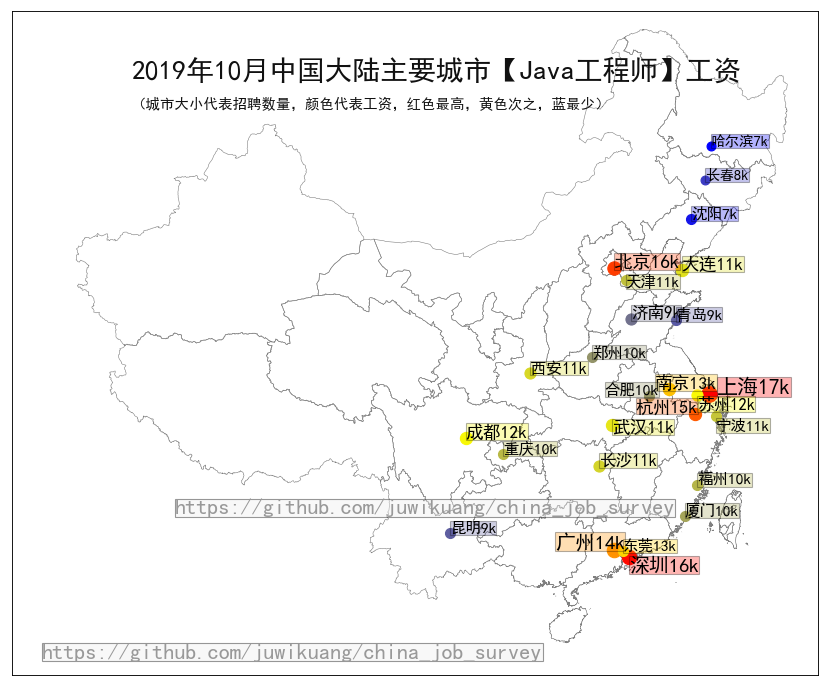

In [29]:
draw_map(data_java, 500, f'{year}年{month}月中国大陆主要城市【Java工程师】工资')

# Python程序员

In [30]:
data_python=get_sub_stats_by_col(data[(data.pl_python==1)],'city')

data_python.style.format(data_format)

,city,平均工资,最低工资,中位数,最高工资,招聘人数,百分比
7,北京,21168,3750,20000,45000,3951,14.07%
4,上海,20741,6280,18750,45833,6196,22.06%
6,深圳,20729,7000,17500,45000,3985,14.19%
0,广州,16982,4500,15000,39219,2870,10.22%
2,杭州,16419,3750,15000,44182,1672,5.95%
10,成都,15683,4500,14000,35000,1323,4.71%
9,南京,15530,4131,15000,30000,1586,5.65%
11,苏州,15194,5145,12500,43182,708,2.52%
1,武汉,14253,4470,12500,30000,1328,4.73%
22,宁波,13769,5131,12500,35000,181,0.64%


In [31]:
describe(data_python, 'Python程序员')

2019年10月北京招收Python程序员3951人。2019年10月北京Python程序员平均工资21168元，工资中位数20000元，其中95%的人的工资介于3750元到45000元。

2019年10月上海招收Python程序员6196人。2019年10月上海Python程序员平均工资20741元，工资中位数18750元，其中95%的人的工资介于6280元到45833元。

2019年10月深圳招收Python程序员3985人。2019年10月深圳Python程序员平均工资20729元，工资中位数17500元，其中95%的人的工资介于7000元到45000元。

2019年10月广州招收Python程序员2870人。2019年10月广州Python程序员平均工资16982元，工资中位数15000元，其中95%的人的工资介于4500元到39219元。

2019年10月杭州招收Python程序员1672人。2019年10月杭州Python程序员平均工资16419元，工资中位数15000元，其中95%的人的工资介于3750元到44182元。

2019年10月成都招收Python程序员1323人。2019年10月成都Python程序员平均工资15683元，工资中位数14000元，其中95%的人的工资介于4500元到35000元。

2019年10月南京招收Python程序员1586人。2019年10月南京Python程序员平均工资15530元，工资中位数15000元，其中95%的人的工资介于4131元到30000元。

2019年10月苏州招收Python程序员708人。2019年10月苏州Python程序员平均工资15194元，工资中位数12500元，其中95%的人的工资介于5145元到43182元。

2019年10月武汉招收Python程序员1328人。2019年10月武汉Python程序员平均工资14253元，工资中位数12500元，其中95%的人的工资介于4470元到30000元。

2019年10月宁波招收Python程序员181人。2019年10月宁波Python程序员平均工资13769元，工资中位数12500元，其中95%的人的工资介于5131元到35000元。

2019年10月长沙招收Python程序员635人。2019年10月长沙Python

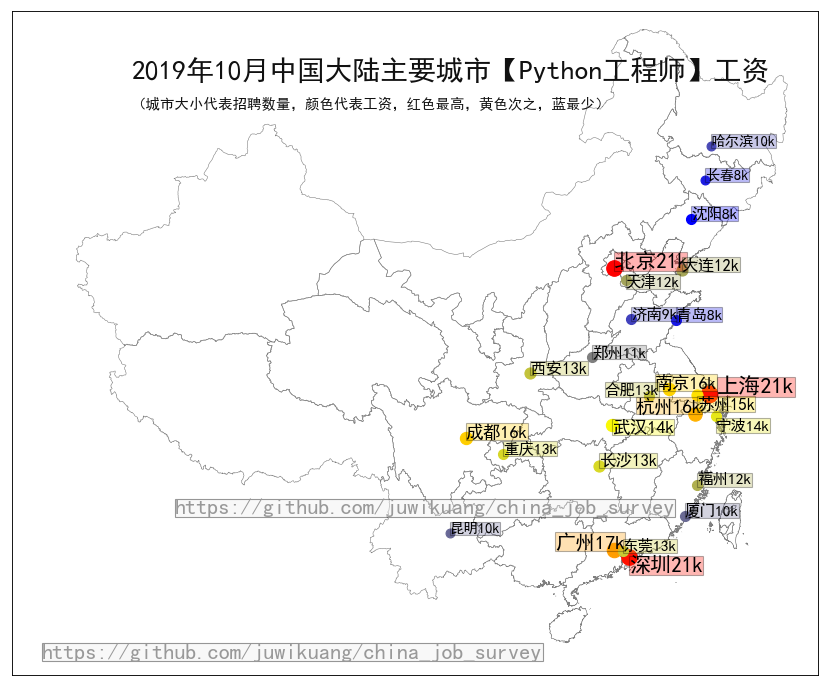

In [32]:
draw_map(data_python, 100,  f'{year}年{month}月中国大陆主要城市【Python工程师】工资')

In [81]:
history_data = pd.read_sql(sql='select * from CityStats', con=conn)

In [82]:
del history_data['Id']

In [83]:
history_data.head()

,Month,City,Salary
0,201906,哈尔滨,5983
1,201906,杭州,14707
2,201906,厦门,9789
3,201906,苏州,11197
4,201906,长沙,10852


In [84]:
data_hangzhou = history_data[history_data.City=='杭州']

In [85]:
del data_hangzhou['City']

In [86]:
import matplotlib.pyplot as plt

In [87]:
data_hangzhou.Salary.values

array([14707, 14980, 15106, 14980, 14758], dtype=int64)

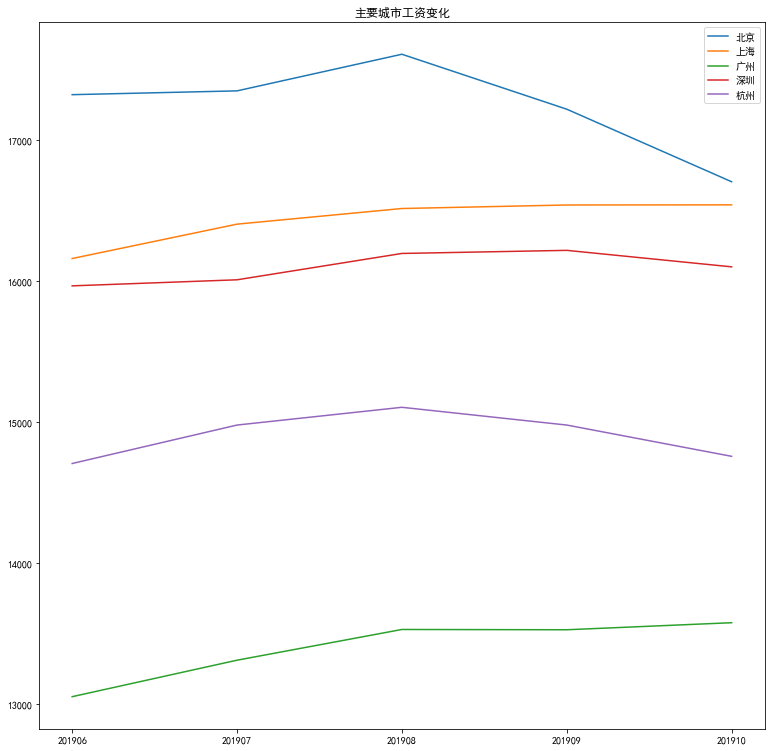

In [91]:
#plt.plot("Month","Salary",data=data_hangzhou, label='杭州')
#plt.plot("Month","Salary",data=history_data[history_data.City=='南京'], label='南京')
cities = set(history_data.City)
cities = ['北京','上海','广州','深圳','杭州']
for city in cities:
    plt.plot("Month","Salary",data=history_data[history_data.City==city], label=city)
    
    #plt.show()
plt.title('主要城市工资变化')
plt.legend()